

# Projet 6 :

# Classifiez automatiquement des biens de consommation

## Préambule :

L'entreprise "Place de marché" est actuellement en train de développer une marketplace e-commerce. La plateforme permet aux vendeurs de proposer leurs articles aux acheteurs en publiant une photo et une description. Cependant, l'attribution manuelle des catégories aux articles par les vendeurs est peu fiable, et le volume d'articles actuellement présent sur la plateforme est encore limité. Afin d'améliorer l'expérience des utilisateurs et de préparer une future expansion, il est devenu nécessaire d'automatiser cette tâche.


## Mission

Notre mission consiste à étudier la faisabilité d'un moteur de classification automatique des articles pour notre marketplace. L'objectif est de mettre en place un système capable d'attribuer automatiquement des catégories aux articles en se basant sur leur description et leur image. 


### Chargement des bibliothèques et des données

In [1]:
!pip install --upgrade numpy
!pip install tensorflow
!pip install --upgrade tensorflow
!pip install --upgrade transformers
!pip install --upgrade torch
!pip install --upgrade tensorflow_hub
!pip install --upgrade tensorflow_text
!pip install spacy
!python -m spacy download fr_core_news_sm
!pip install -U spacy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
import string
from nltk.stem import SnowballStemmer
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
import spacy
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import normalize
from nltk.stem.snowball import SnowballStemmer
nltk.download('wordnet')
nltk.download('omw-1.4')
from sklearn.preprocessing import LabelEncoder
from nltk.stem import PorterStemmer, WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
import re
from collections import Counter
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.preprocessing import normalize
from gensim.models import Word2Vec
import tensorflow as tf
from transformers import BertTokenizer, BertModel
import torch
import tensorflow_hub as hub
import tensorflow_text
!pip install WordCloud
from wordcloud import WordCloud
import os

  Using cached numpy-1.25.0-cp39-cp39-macosx_10_9_x86_64.whl (20.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.23.5
    Uninstalling numpy-1.23.5:
      Successfully uninstalled numpy-1.23.5
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
daal4py 2021.6.0 requires daal==2021.4.0, which is not installed.
tensorflow 2.12.0 requires numpy<1.24,>=1.22, but you have numpy 1.25.0 which is incompatible.
scipy 1.9.1 requires numpy<1.25.0,>=1.18.5, but you have numpy 1.25.0 which is incompatible.
numba 0.55.1 requires numpy<1.22,>=1.18, but you have numpy 1.25.0 which is incompatible.
  Using cached numpy-1.23.5-cp39-cp39-macosx_10_9_x86_64.whl (18.1 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.25.0
    Uninstalling numpy-1.25.0:
      Successfully uninstalled numpy-1.25.0
ERROR: pip's dependency resolver does

2023-06-28 20:42:55.381205: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
[nltk_data] Downloading package wordnet to /Users/azizi/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /Users/azizi/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [2]:
# Chargement des données df
df = pd.read_csv('flipkart_com-ecommerce_sample_1050.csv')

In [3]:
# Afficher les 2 premières lignes du jeu de données df
df.head(2)

uniq_id            crawl_timestamp  \
0  55b85ea15a1536d46b7190ad6fff8ce7  2016-04-30 03:22:56 +0000   
1  7b72c92c2f6c40268628ec5f14c6d590  2016-04-30 03:22:56 +0000   

                                         product_url  \
0  http://www.flipkart.com/elegance-polyester-mul...   
1  http://www.flipkart.com/sathiyas-cotton-bath-t...   

                                        product_name  \
0  Elegance Polyester Multicolor Abstract Eyelet ...   
1                         Sathiyas Cotton Bath Towel   

                               product_category_tree               pid  \
0  ["Home Furnishing >> Curtains & Accessories >>...  CRNEG7BKMFFYHQ8Z   
1  ["Baby Care >> Baby Bath & Skin >> Baby Bath T...  BTWEGFZHGBXPHZUH   

   retail_price  discounted_price                                 image  \
0        1899.0             899.0  55b85ea15a1536d46b7190ad6fff8ce7.jpg   
1         600.0             449.0  7b72c92c2f6c40268628ec5f14c6d590.jpg   

   is_FK_Advantage_product                                        description  \
0                    False  Key Features of Elegance Polyester Multicolor ...   
1                    False  Specifications of Sathiyas Cotton Bath Towel (...   

        product_rating       overall_rating     brand  \
0  No rating available  No rating available  Elegance   
1  No rating available  No rating available  Sathiyas   

                              product_specifications  
0  {"product_specification"=>[{"key"=>"Brand", "v...  
1  {"product_specification"=>[{"key"=>"Machine Wa...

In [4]:
# Chargement des données df
data = pd.read_csv('data.csv')
data.head(2)

product_description        categorie
0  [ ' elegance ' , ' polyester ' , ' multicolor ...  Home Furnishing
1  [ ' sathiyas ' , ' cotton ' , ' bath ' , ' tow...        Baby Care

In [5]:
# Combiner les colonnes "image" et "categorie" des DataFrames df et data
data_image = pd.concat([df['image'], data['categorie']], axis=1)
data_image


image        categorie
0     55b85ea15a1536d46b7190ad6fff8ce7.jpg  Home Furnishing
1     7b72c92c2f6c40268628ec5f14c6d590.jpg        Baby Care
2     64d5d4a258243731dc7bbb1eef49ad74.jpg        Baby Care
3     d4684dcdc759dd9cdf41504698d737d8.jpg  Home Furnishing
4     6325b6870c54cd47be6ebfbffa620ec7.jpg  Home Furnishing
...                                    ...              ...
1045  958f54f4c46b53c8a0a9b8167d9140bc.jpg        Baby Care
1046  fd6cbcc22efb6b761bd564c28928483c.jpg        Baby Care
1047  5912e037d12774bb73a2048f35a00009.jpg        Baby Care
1048  c3edc504d1b4f0ba6224fa53a43a7ad6.jpg        Baby Care
1049  f2f027ad6a6df617c9f125173da71e44.jpg        Baby Care

[1050 rows x 2 columns]

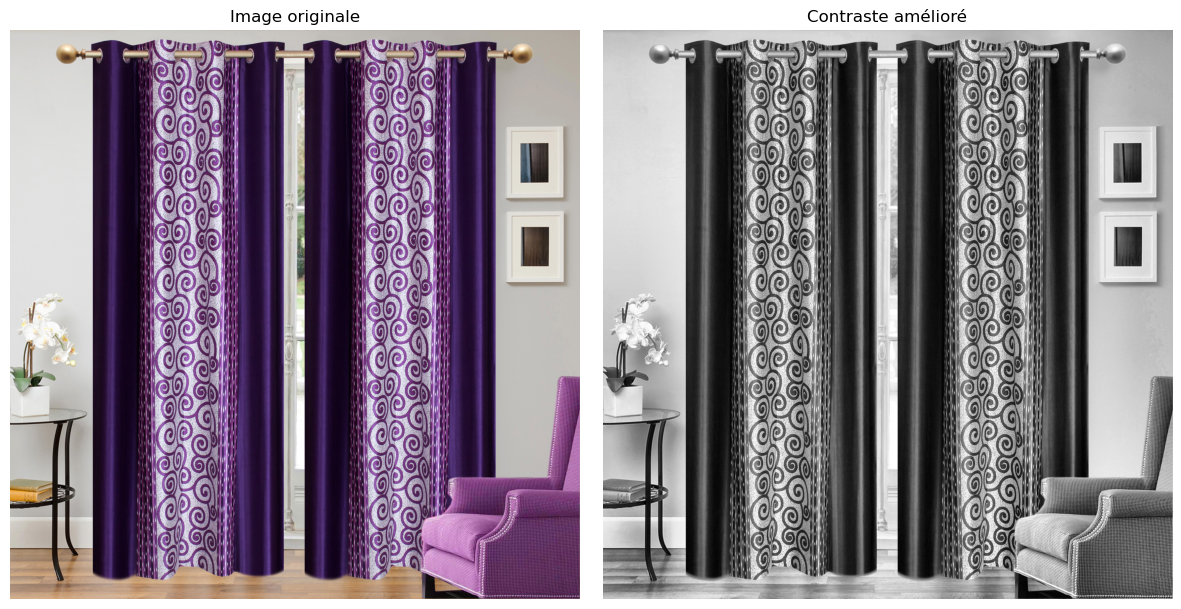

In [6]:
import cv2
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Ajustement automatique du contraste
    clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
    enhanced = clahe.apply(gray)

    return enhanced

# Chemin d'accès du fichier d'image
chemin_image = "/Users/azizi/Desktop/Flipkart/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg"

# Chargement de l'image en couleur
image = cv2.imread(chemin_image)

if image is not None:
    # Création de la figure avec deux sous-plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 6))
    
    # Affichage de l'image originale en couleur
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image originale")
    axes[0].axis("off")

    # Prétraitement de l'image
    preprocessed_image = preprocess_image(image)
    
    # Affichage de l'image après le premier traitement de contraste
    axes[1].imshow(preprocessed_image, cmap="gray")
    axes[1].set_title("Contraste amélioré")
    axes[1].axis("off")
    
    # Ajustement des espacements entre les sous-plots
    plt.tight_layout()
    
    # Affichage de la figure
    plt.show()
else:
    print(f"Erreur lors du chargement de l'image : {chemin_image}")


Catégorie : Home Furnishing


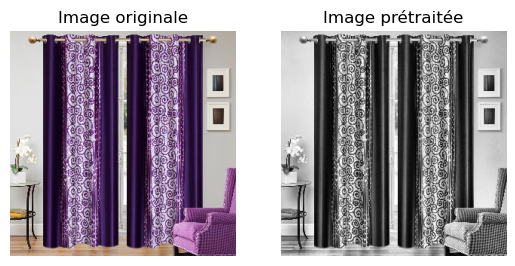

Catégorie : Home Furnishing


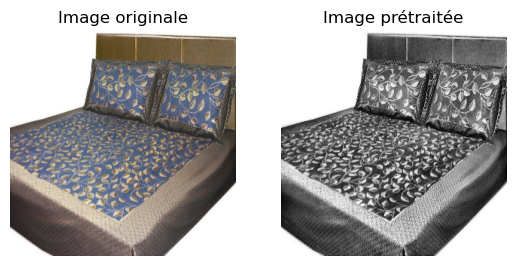

Catégorie : Baby Care


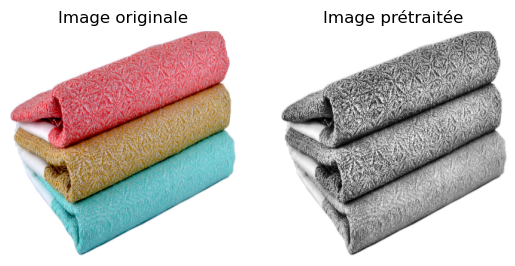

Catégorie : Baby Care


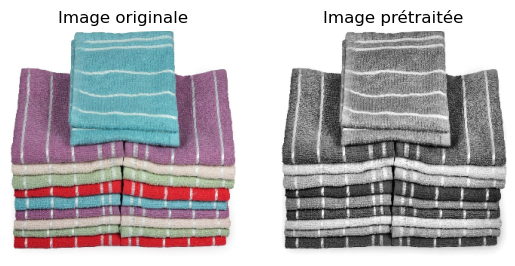

Catégorie : Watches


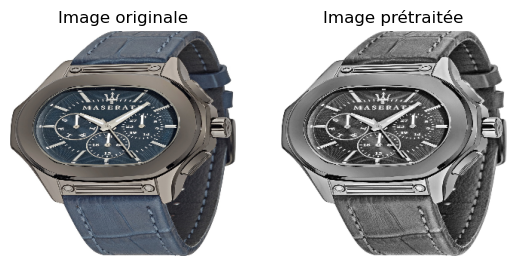

Catégorie : Watches


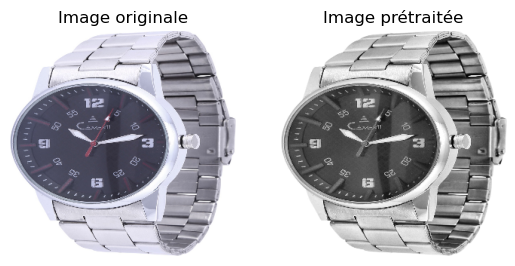

Catégorie : Home Decor & Festive Needs


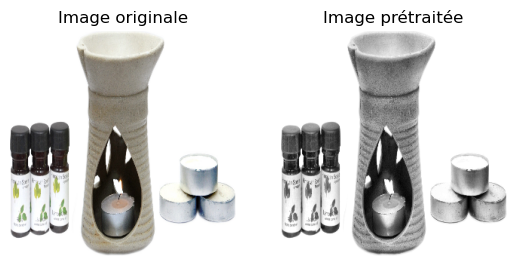

Catégorie : Home Decor & Festive Needs


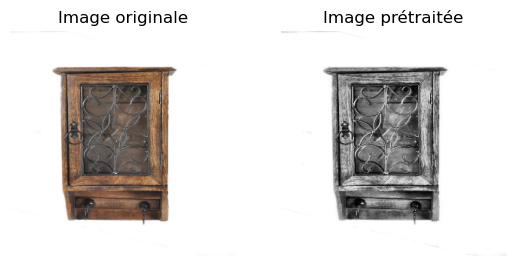

Catégorie : Kitchen & Dining


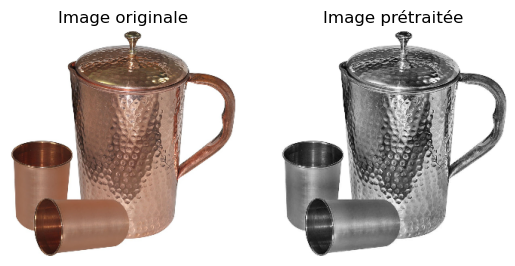

Catégorie : Kitchen & Dining


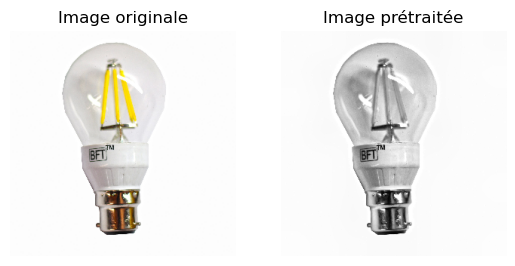

Catégorie : Beauty and Personal Care


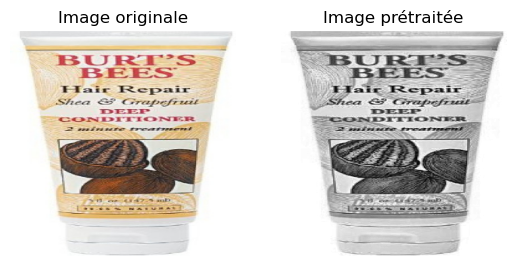

Catégorie : Beauty and Personal Care


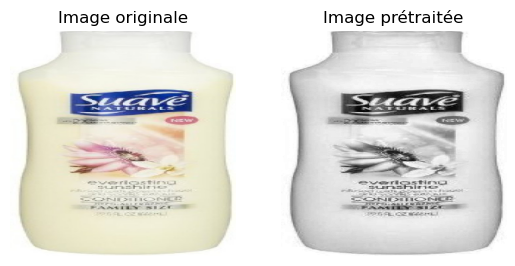

Catégorie : Computers


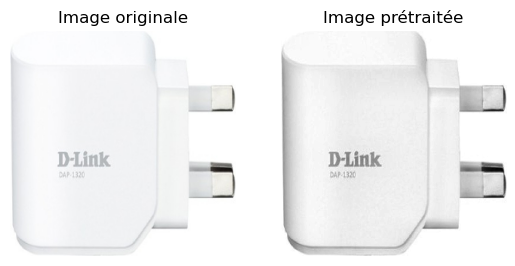

Catégorie : Computers


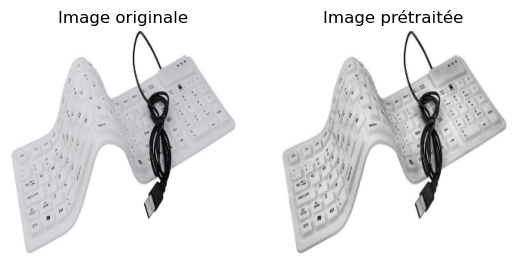

In [7]:
# Chemin d'accès du répertoire contenant les images
chemin_repertoire = "/Users/azizi/Desktop/Flipkart/Images"

# Taille de l'image redimensionnée
nouvelle_largeur = 300
nouvelle_hauteur = 300

# Parcourir chaque catégorie
categories = data_image["categorie"].unique()
for categorie in categories:
    # Filtrer les images par catégorie
    images_categorie = data_image[data_image["categorie"] == categorie]

    # Compteur pour limiter le nombre d'images affichées
    count = 0

    # Parcourir les images de la catégorie
    for image_name in images_categorie["image"].values:
        # Vérifier si le nombre d'images affichées a atteint la limite
        if count >= 2:
            break
        
        # Chemin d'accès complet de l'image
        chemin_image = os.path.join(chemin_repertoire, image_name)

        # Charger l'image avec OpenCV
        image = cv2.imread(chemin_image)

        # Redimensionner l'image
        image_resized = cv2.resize(image, (nouvelle_largeur, nouvelle_hauteur))

        # Appliquer le prétraitement à l'image redimensionnée
        preprocessed_image = preprocess_image(image_resized)

        # Afficher le nom de la catégorie
        print("Catégorie :", categorie)

        # Afficher l'image originale
        plt.subplot(1, 2, 1)
        plt.imshow(cv2.cvtColor(image_resized, cv2.COLOR_BGR2RGB))
        plt.axis('off')  # Supprimer les axes
        plt.title("Image originale")

        # Afficher l'image prétraitée
        plt.subplot(1, 2, 2)
        plt.imshow(preprocessed_image, cmap='gray')
        plt.axis('off')  # Supprimer les axes
        plt.title("Image prétraitée")

        # Afficher les images
        plt.show()
        
        # Augmenter le compteur
        count += 1


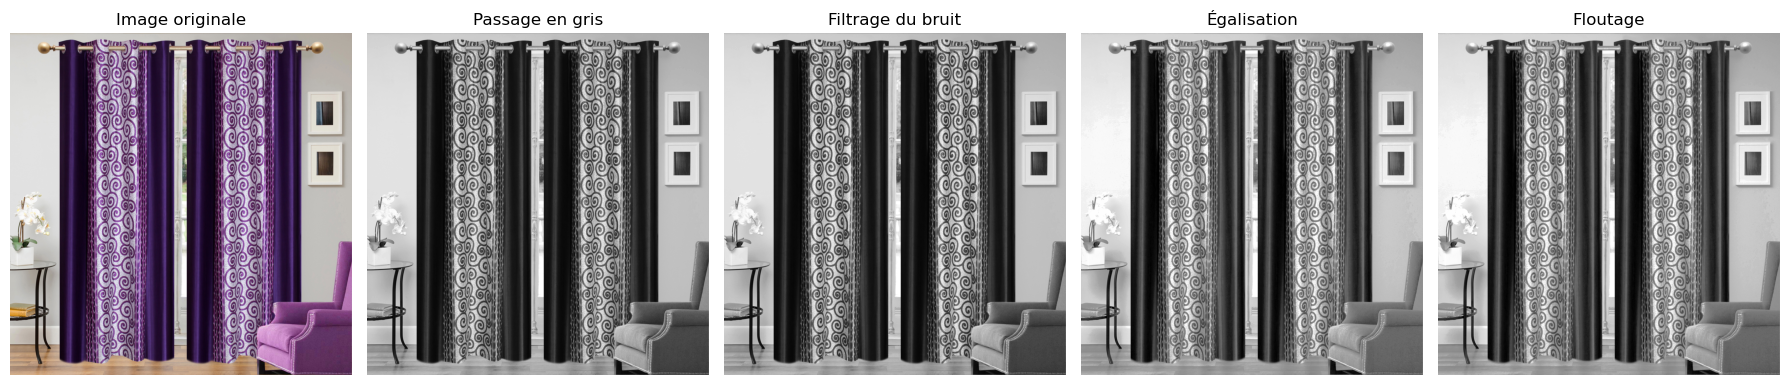

In [8]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt

def preprocess_image(image):
    # Conversion en niveaux de gris
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Filtrage du bruit avec un filtre médian
    denoised = cv2.medianBlur(gray, 5)

    # Égalisation d'histogramme
    equalized = cv2.equalizeHist(denoised)

    # Floutage de l'image
    blurred = cv2.GaussianBlur(equalized, (5, 5), 0)

    return gray, denoised, equalized, blurred

# Chemin d'accès du fichier d'image
chemin_image = "/Users/azizi/Desktop/Flipkart/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg"

# Chargement de l'image en couleur
image = cv2.imread(chemin_image)

if image is not None:
    # Prétraitement de l'image
    gray, denoised, equalized, blurred = preprocess_image(image)

    # Création de la figure avec sous-plots
    fig, axes = plt.subplots(1, 5, figsize=(18, 6))
    
    # Affichage de l'image originale en couleur
    axes[0].imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
    axes[0].set_title("Image originale")
    axes[0].axis("off")

    # Affichage des étapes de prétraitement
    images = [gray, denoised, equalized, blurred]
    titles = ["Passage en gris", "Filtrage du bruit", "Égalisation", "Floutage"]
    
    for i in range(1, 5):
        axes[i].imshow(images[i-1], cmap="gray")
        axes[i].set_title(titles[i-1])
        axes[i].axis("off")

    # Ajustement des espacements entre les sous-plots
    plt.tight_layout()
    
    # Affichage de la figure
    plt.show()
else:
    print(f"Erreur lors du chargement de l'image : {chemin_image}")


### Descripteurs SIFT

on va s'inspirer des cours d'openclassrooms : https://openclassrooms.com/fr/paths/164/projects/631/resources

[ WARN:0@10.122] global shadow_sift.hpp:15 SIFT_create DEPRECATED: cv.xfeatures2d.SIFT_create() is deprecated due SIFT tranfer to the main repository. https://github.com/opencv/opencv/issues/16736


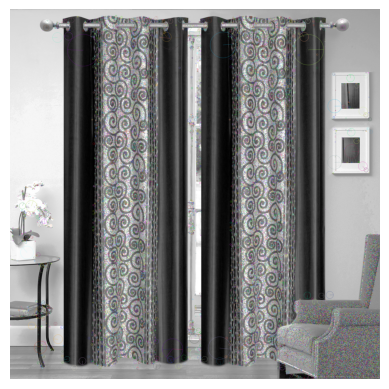

Descripteurs : (98204, 128)

[[  0.   0.   0. ...   0.   0.   0.]
 [  7.   0.   0. ...   3.   0.   7.]
 [ 12.   6.   3. ...   4.   0.   0.]
 ...
 [113.  43.  54. ...   0.   0.   0.]
 [ 33.  14.   3. ...  16.   5.   3.]
 [ 57.  32. 118. ...   0.   0.   0.]]


In [9]:
import cv2
import matplotlib.pyplot as plt

# Chemin d'accès à l'image
path = "/Users/azizi/Desktop/Flipkart/Images/55b85ea15a1536d46b7190ad6fff8ce7.jpg"

# Initialisation de l'algorithme SIFT
sift = cv2.xfeatures2d.SIFT_create()

# Chargement de l'image en niveaux de gris
image = cv2.imread(path, 0)  # Convertir en niveaux de gris

# Égalisation de l'histogramme de l'image
image = cv2.equalizeHist(image)

# Détection des points clés et des descripteurs SIFT
kp, des = sift.detectAndCompute(image, None)

# Dessiner les points clés sur l'image
img_with_keypoints = cv2.drawKeypoints(image, kp, image, flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Affichage de l'image avec les points clés
plt.imshow(img_with_keypoints)
plt.axis("off")
plt.show()

# Affichage des informations sur les descripteurs
print("Descripteurs :", des.shape)
print()
print(des)


## Pré-traitement des images via SIFT
### Créations des descripteurs de chaque image


In [10]:
import time
import cv2
import numpy as np

chemin = "/Users/azizi/Desktop/Flipkart/Images/"
sift_keypoints = []
temps1 = time.time()
sift = cv2.xfeatures2d.SIFT_create(500)

for i in range(data_image.shape[0]):
    if i % 100 == 0:
        print(i)
    image = cv2.imread(chemin + data_image['image'].iloc[i], 0)  # convertir en niveaux de gris
    res = cv2.equalizeHist(image)  # égaliser l'histogramme de l'image
    kp, des = sift.detectAndCompute(res, None)
    if des is not None:
        sift_keypoints.append(des)

sift_keypoints_par_image = np.asarray(sift_keypoints)
sift_keypoints_globaux = np.concatenate(sift_keypoints_par_image, axis=0)

print()
print("Nombre de descripteurs :", sift_keypoints_globaux.shape)

duree1 = time.time() - temps1
print("Temps de traitement des descripteurs SIFT :", "%15.2f" % duree1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000


/var/folders/47/jf50ppr146l7xm_wqy7ffcfr0000gn/T/ipykernel_8165/2943387675.py:19: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  sift_keypoints_par_image = np.asarray(sift_keypoints)



Nombre de descripteurs : (517351, 128)
Temps de traitement des descripteurs SIFT :          754.68 secondes


### Création des clusters de descripteurs
Utilisation de MiniBatchKMeans pour obtenir des temps de traitement raisonnables

In [11]:
import time
from sklearn import cluster, metrics
from sklearn.cluster import MiniBatchKMeans

# Détermination du nombre de clusters
temps1 = time.time()

k = int(round(np.sqrt(len(sift_keypoints_globaux)), 0))
print("Nombre de clusters estimés :", k)
print("Création de", k, "clusters de descripteurs ...")

# Clustering
kmeans = cluster.MiniBatchKMeans(n_clusters=k, init_size=3*k, random_state=0)
kmeans.fit(sift_keypoints_globaux)

duree1 = time.time() - temps1
print("Temps de traitement k-means :", "%15.2f" % duree1, "secondes")


Nombre de clusters estimés : 719
Création de 719 clusters de descripteurs ...


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 3 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


Temps de traitement k-means :            9.41 secondes


## Création des features des images
* Pour chaque image : 
   - prédiction des numéros de cluster de chaque descripteur
   - création d'un histogramme = comptage pour chaque numéro de cluster du nombre de descripteurs de l'image

Features d'une image = Histogramme d'une image = Comptage pour une image du nombre de descripteurs par cluster

In [12]:
temps1 = time.time()

def build_histogram(kmeans, des, image_num):
    res = kmeans.predict(des)
    hist = np.zeros(len(kmeans.cluster_centers_))
    nb_des = len(des)
    if nb_des == 0:
        print("Problème d'histogramme pour l'image :", image_num)
    for i in res:
        hist[i] += 1.0 / nb_des
    return hist

hist_vectors = []

for i, image_desc in enumerate(sift_keypoints_par_image):
    if i % 100 == 0:
        print(i)
    hist = build_histogram(kmeans, image_desc, i)  # calcule l'histogramme
    hist_vectors.append(hist)  # l'histogramme est le vecteur de caractéristiques

im_features = np.asarray(hist_vectors)

duration1 = time.time() - temps1
print("Temps de création des histogrammes :", "%15.2f" % duration1, "secondes")


0
100
200
300
400
500
600
700
800
900
1000
Temps de création des histogrammes :            2.79 secondes


## Réductions de dimension

### Réduction de dimension PCA
* La réduction PCA permet de créer des features décorrélées entre elles, et de diminuer leur dimension, tout en gardant un niveau de variance expliquée élevé (99%)
* L'impact est une meilleure séparation des données via le T-SNE et une réduction du temps de traitement du T-SNE

In [13]:
from sklearn import decomposition

print("Dimensions du dataset avant réduction PCA :", im_features.shape)
pca = decomposition.PCA(n_components=0.99)
feat_pca = pca.fit_transform(im_features)
print("Dimensions du dataset après réduction PCA :", feat_pca.shape)


Dimensions du dataset avant réduction PCA : (1050, 719)
Dimensions du dataset après réduction PCA : (1050, 495)


### Réduction de dimension T-SNE
* Réduction de dimension en 2 composantes T-SNE pour affichage en 2D des images

In [14]:
from sklearn import manifold, decomposition

tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['tsne1', 'tsne2'])
df_tsne["class"] = data_image["categorie"]
print(df_tsne.shape)


(1050, 3)


## Analyse visuelle : affichage T-SNE selon catégories d'images


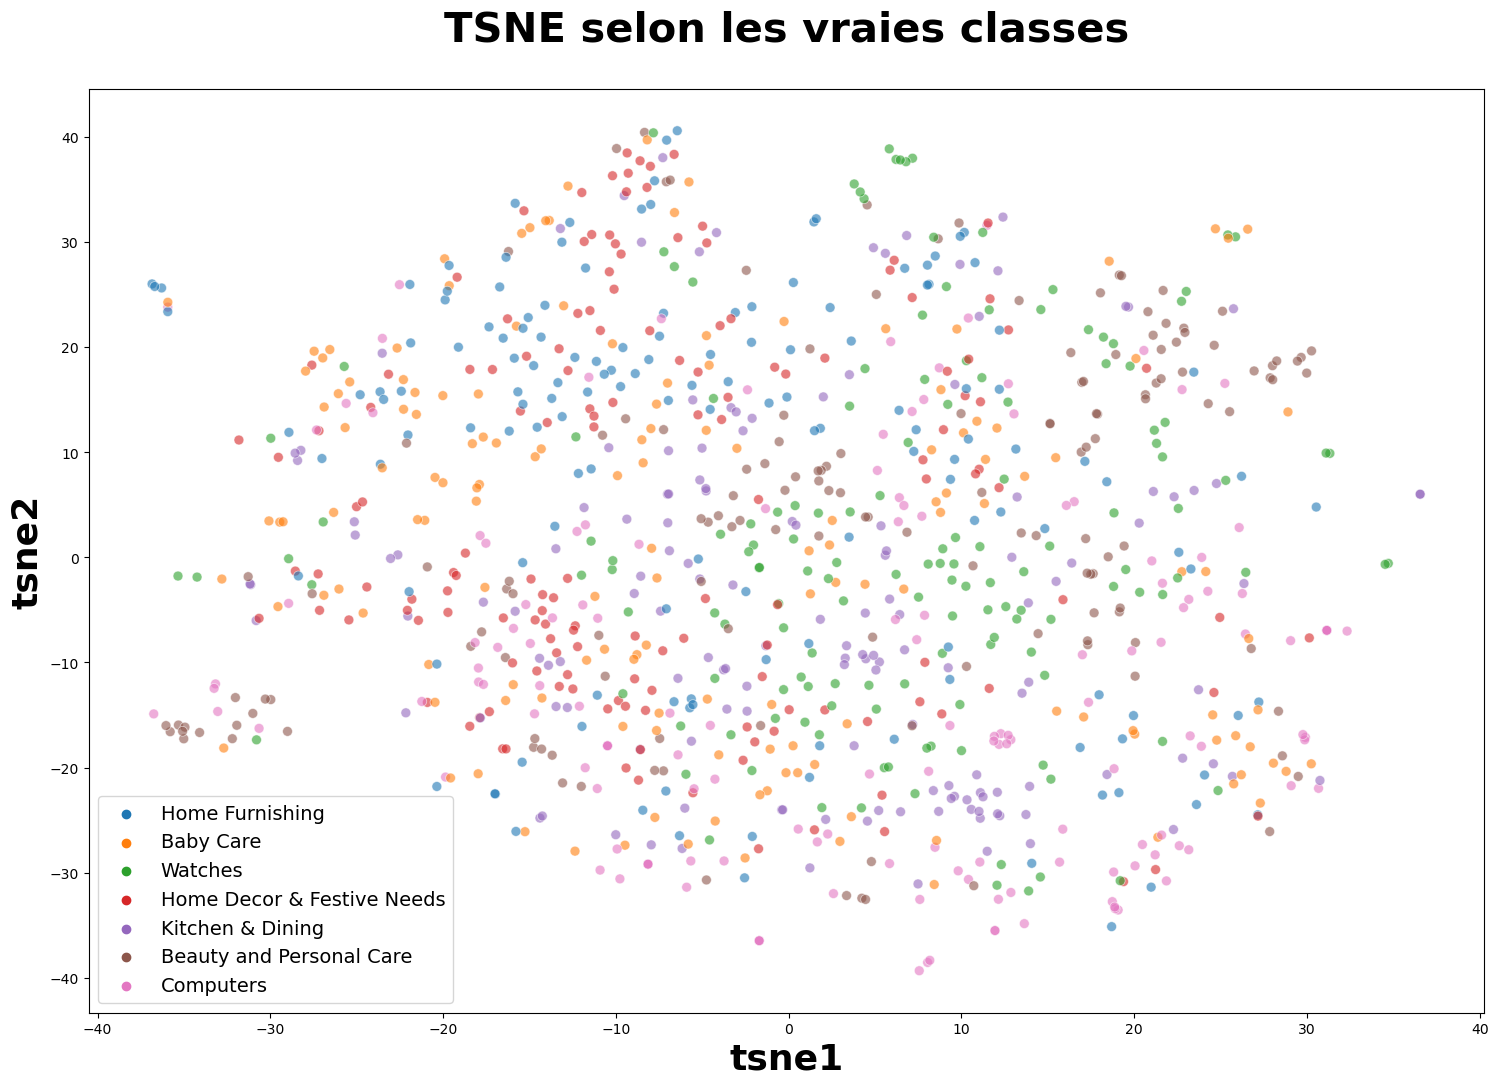

In [15]:
plt.figure(figsize=(18, 12))
sns.scatterplot(
    x="tsne1", y="tsne2", hue="class", data=df_tsne, legend="brief",
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6)

plt.title('TSNE selon les vraies classes', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14})

plt.show()


## Analyse mesures : similarité entre catégories et clusters
###  Création de clusters à partir du T-SNE

In [16]:
from sklearn import cluster, metrics
from sklearn.preprocessing import LabelEncoder

cls = cluster.KMeans(n_clusters=7, random_state=6)
cls.fit(X_tsne)

df_tsne["cluster"] = cls.labels_

# Création d'un encodeur de labels
label_encoder = LabelEncoder()
df_tsne["cluster_num"] = label_encoder.fit_transform(df_tsne["cluster"])

print(df_tsne.shape)


(1050, 5)


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


##  Affichage des images selon clusters et calcul ARI de similarité catégories images / clusters


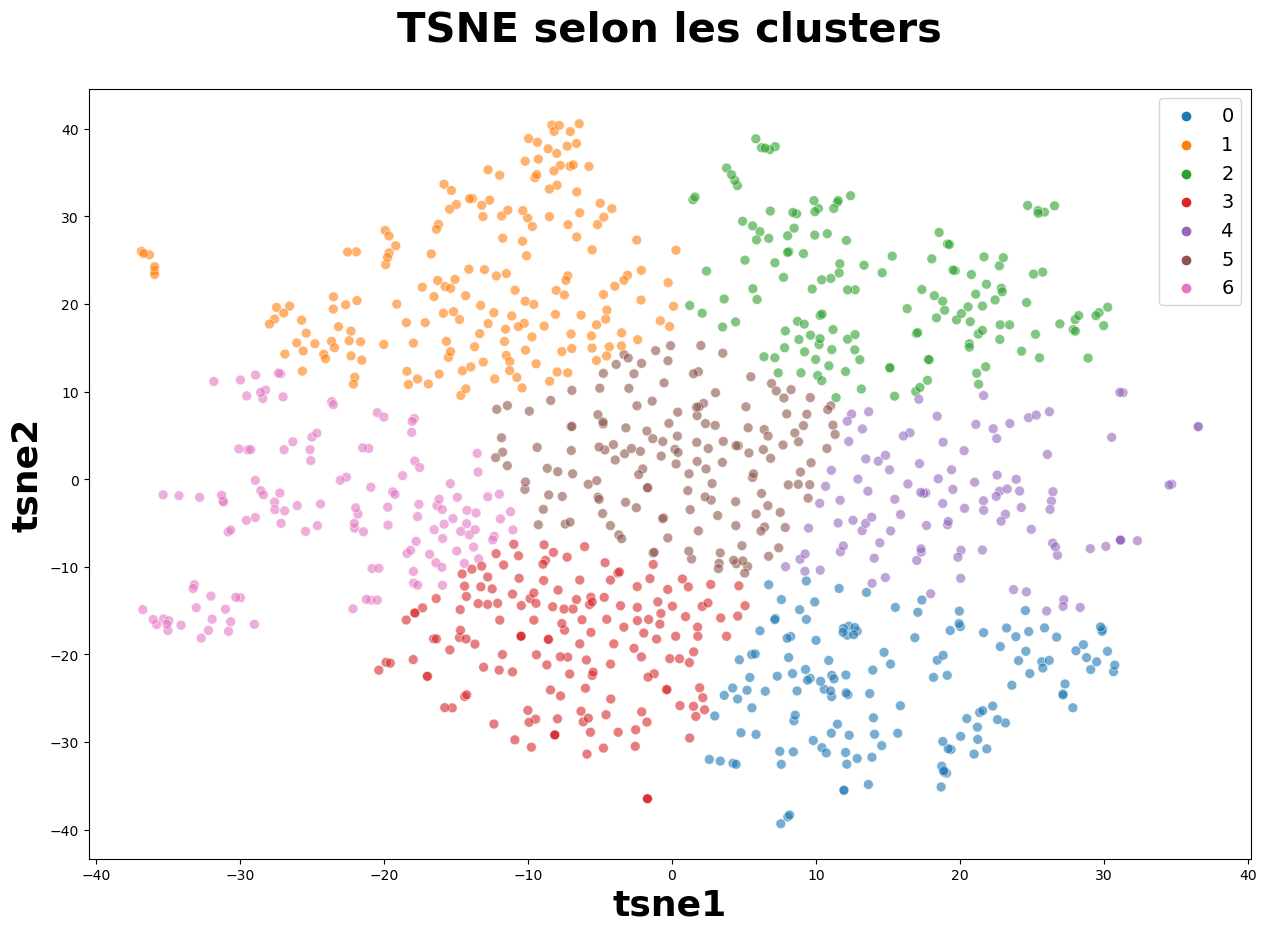

ARI :  0.05200494688157496


In [17]:

# Création du graphique avec seaborn
plt.figure(figsize=(15,10))
sns.scatterplot(
    x="tsne1", y="tsne2",
    hue="cluster_num",  # Utilisation de la nouvelle colonne "cluster_num"
    palette=sns.color_palette('tab10', n_colors=7), s=50, alpha=0.6,
    data=df_tsne,
    legend="brief")

# Paramètres du graphique
plt.title('TSNE selon les clusters', fontsize=30, pad=35, fontweight='bold')
plt.xlabel('tsne1', fontsize=26, fontweight='bold')
plt.ylabel('tsne2', fontsize=26, fontweight='bold')
plt.legend(prop={'size': 14}) 

plt.show()

# Calcul de l'indice ARI
labels = data_image["categorie"]
print("ARI : ", metrics.adjusted_rand_score(labels, cls.labels_))


Le score ARI de 0.052 indique une faible similitude entre les étiquettes réelles des catégories et les clusters obtenus.

In [18]:
df_tsne.groupby("cluster").count()["class"]

cluster
0    146
1    186
2    150
3    167
4    110
5    159
6    132
Name: class, dtype: int64

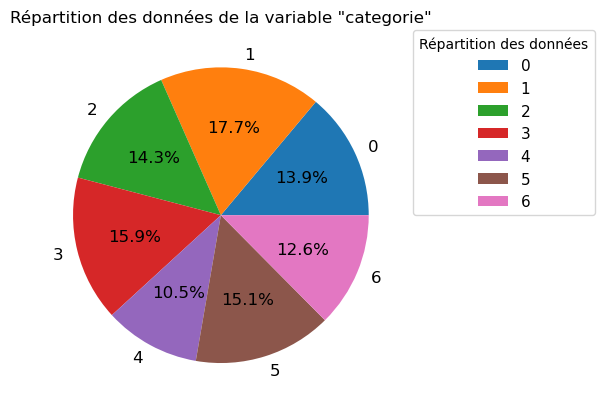

In [19]:

# Répartition des données de la variable "categorie"
plt.title('Répartition des données de la variable "categorie"', size=12)
wedges, texts, autotexts = plt.pie(df_tsne.groupby("cluster").size(),
                                   labels=df_tsne.groupby("cluster").size().index,
                                   autopct='%1.1f%%',
                                   textprops={'fontsize': 12, 'color': 'black'})

ax = plt.gca()
ax.legend(wedges,
          df_tsne.groupby("cluster").size().index,
          title='Répartition des données',
          loc="center left",
          fontsize=11,
          bbox_to_anchor=(1.0, 0.5, 0.2, 0.5))

plt.show()


## Matrice de confusion 

Correspondance des clusters : [3, 1, 2, 0]
[[19 63 20 13 12 15  8]
 [30 41 14 19  5 18 23]
 [18  7 33 18 31 35  8]
 [33 48 13  8  6  9 33]
 [25  9 12 31 16 41 16]
 [13 10 47  9 20 28 23]
 [29  8 11 48 20 13 21]]

              precision    recall  f1-score   support

           0       0.11      0.13      0.12       150
           1       0.22      0.27      0.24       150
           2       0.22      0.22      0.22       150
           3       0.05      0.05      0.05       150
           4       0.15      0.11      0.12       150
           5       0.18      0.19      0.18       150
           6       0.16      0.14      0.15       150

    accuracy                           0.16      1050
   macro avg       0.16      0.16      0.16      1050
weighted avg       0.16      0.16      0.16      1050



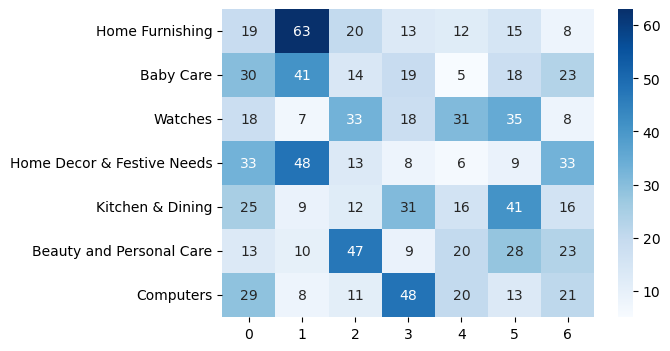

In [20]:

from sklearn import metrics

def conf_mat_transform(y_true, y_pred):
    conf_mat = metrics.confusion_matrix(y_true, y_pred)
    
    corresp = [3, 1, 2, 0]  # Correspondance des clusters
    print("Correspondance des clusters :", corresp)
    
    labels = pd.Series(y_true, name="y_true").to_frame()
    labels['y_pred'] = y_pred
    labels['y_pred_transform'] = labels['y_pred'].apply(lambda x: corresp[x] if x < len(corresp) else x)
    
    return labels['y_pred_transform']

# Conversion des labels en nombres
label_mapping = {label: i for i, label in enumerate(data_image['categorie'].unique())}
labels_numeric = data_image['categorie'].map(label_mapping)

cls_labels_transform = conf_mat_transform(labels_numeric, cls.labels_)
conf_mat = metrics.confusion_matrix(labels_numeric, cls_labels_transform)
print(conf_mat)
print()
print(metrics.classification_report(labels_numeric, cls_labels_transform))

# Création du DataFrame de la matrice de confusion
clusters = np.unique(cls.labels_)
categories = [label for label in label_mapping]
df_cm = pd.DataFrame(conf_mat, index=categories, columns=clusters)
plt.figure(figsize=(6, 4))
sns.heatmap(df_cm, annot=True, cmap="Blues")
plt.show()


## Transfer Learning : VGG-16 | CNN model 

https://openclassrooms.com/fr/courses/4470531-classez-et-segmentez-des-donnees-visuelles/5097666-tp-implementez-votre-premier-reseau-de-neurones-avec-keras

Le VGG-16 est un réseau neuronal composé de 16 couches, dont 13 sont des couches de convolution et 3 sont des couches fully-connected. Il est utilisé pour classer des images en entrée de taille 224 × 224 pixels parmi 1000 classes possibles. Le réseau renvoie un vecteur de probabilités de taille 1000, indiquant la probabilité d'appartenance de l'image à chaque classe.

Les couches de convolution utilisent des filtres de taille 3 × 3 pixels avec un déplacement d'un pixel. Un padding de 1 pixel est utilisé pour conserver les dimensions d'entrée et de sortie identiques. Le nombre de filtres varie selon le bloc de la couche. Chaque couche de convolution est suivie d'une fonction d'activation ReLU.

Les opérations de pooling sont effectuées avec des cellules de taille 2 × 2 pixels et un pas de 2 pixels, sans chevauchement entre les cellules.

Les deux premières couches fully-connected génèrent des vecteurs de taille 4096, suivis chacun d'une couche ReLU. La dernière couche fully-connected produit un vecteur de probabilités de taille 1000 en utilisant la fonction softmax. Chacune de ces couches utilise un paramètre de biais pour chaque élément du vecteur de sortie.

https://www.geeksforgeeks.org/vgg-16-cnn-model/

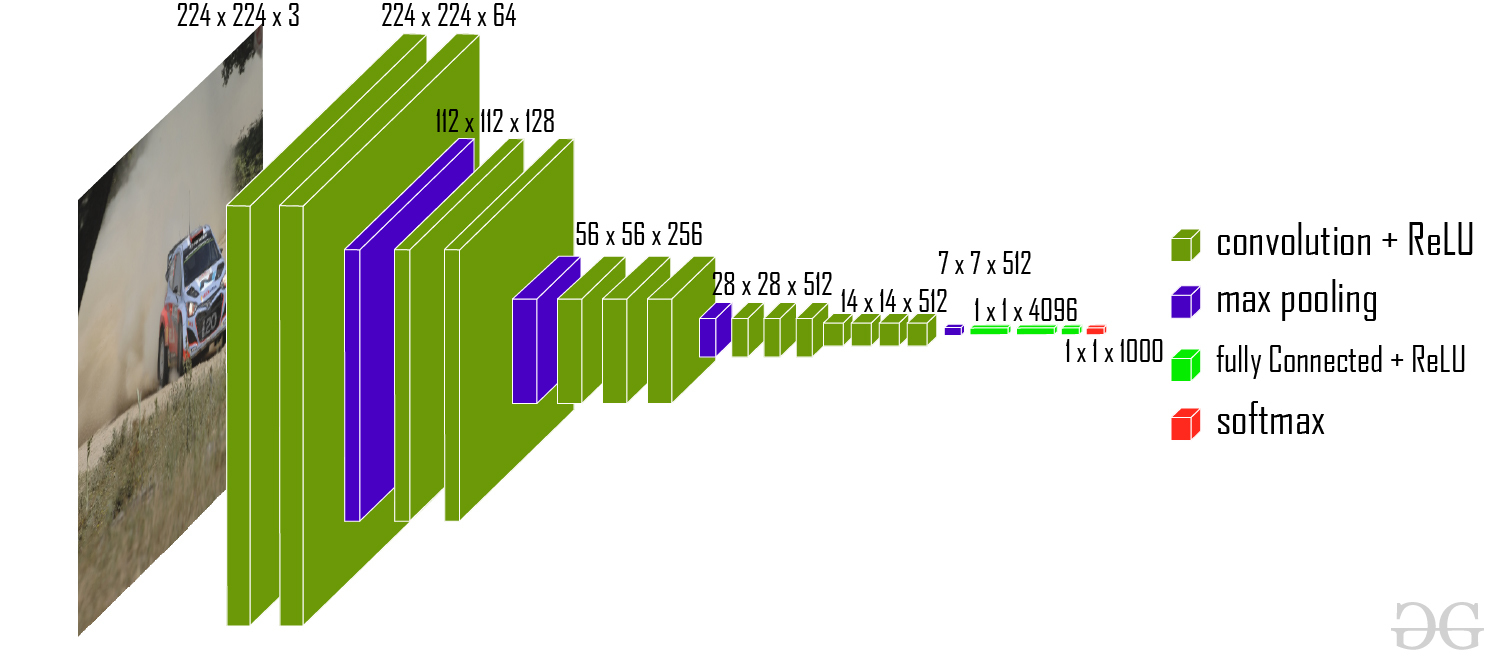

### Modification du modèle  VGG-16

Nous commençons par charger le modèle VGG16 sans les couches de classification. Ensuite, nous ajoutons de nouvelles couches de classification qui consistent en une couche de mise à plat (Flatten), une couche dense avec une activation ReLU (Dense) et une couche de sortie avec une activation softmax. Ces couches permettent de classer les images en 7 catégories différentes. 

In [21]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

# Load the pre-trained VGG16 model without the top (fully connected) layers
base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Freeze the layers in the base model
for layer in base_model.layers:
    layer.trainable = False
    
# Create a new model on top of the base model
model = models.Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(256, activation='relu'))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(7, activation='softmax')) 

# Compile the model
model.compile(optimizer=optimizers.RMSprop(lr=1e-3),
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 7, 7, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 25088)             0         
                                                                 
 dense (Dense)               (None, 512)               12845568  
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 256)               131328    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense_2 (Dense)             (None, 7)                 1

In [22]:
from keras.utils import load_img, img_to_array
from keras.applications.vgg16 import preprocess_input

# Charger l'image
images = []
path = "/Users/azizi/Desktop/Flipkart/Images/"
for filename in data_image['image']:
    img = load_img(path+filename, target_size=(224, 224))  
    img = img_to_array(img)  # Convertir en tableau numpy
    images.append(img)
images = np.array(images)

# Prétraitement de l'image 
images = preprocess_input(images)
images.shape

/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/PIL/Image.py:3035: DecompressionBombWarning: Image size (93680328 pixels) exceeds limit of 89478485 pixels, could be decompression bomb DOS attack.
  warnings.warn(


(1050, 224, 224, 3)

In [23]:
# Création des features des images
features = model.predict(images)
features.shape

33/33 [==============================] - 310s 9s/step


(1050, 7)

## Analyse visuelle : affichage T-SNE selon catégories d'images


Dimensions dataset avant réduction PCA : (1050, 7)
Dimensions dataset après réduction PCA : (1050, 5)


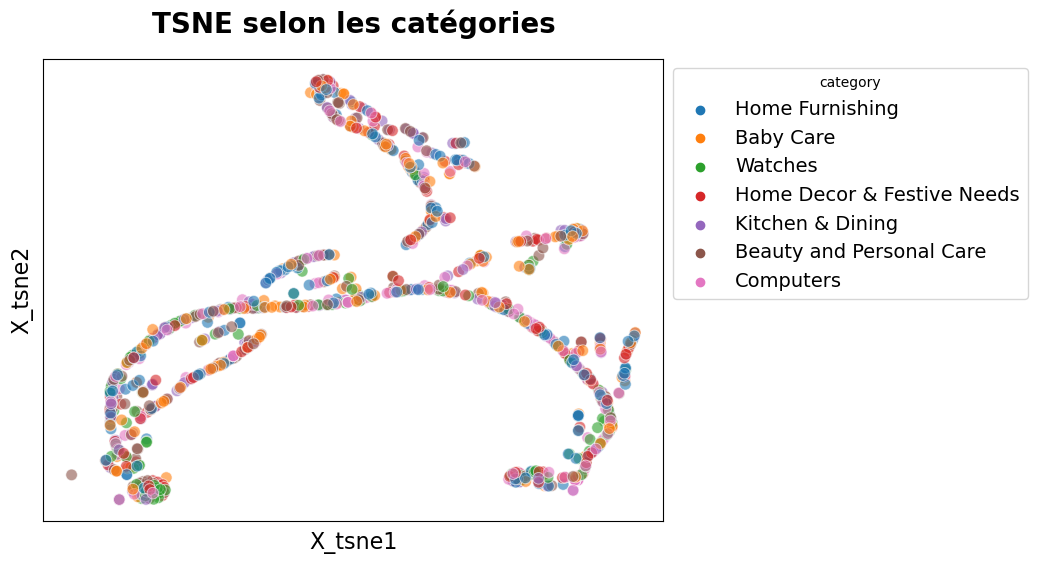

In [24]:

print("Dimensions dataset avant réduction PCA :", features.shape)

# Réduction de dimension avec PCA
pca = PCA(n_components=0.99)
feat_pca = pca.fit_transform(features)

print("Dimensions dataset après réduction PCA :", feat_pca.shape)

# Réduction de dimension avec t-SNE
tsne = manifold.TSNE(n_components=2, perplexity=30, n_iter=2000, init='random', random_state=6)
X_tsne = tsne.fit_transform(feat_pca)

# Création d'un DataFrame pour le graphique
df_tsne = pd.DataFrame(X_tsne[:, 0:2], columns=['X_tsne1', 'X_tsne2'])
df_tsne["category"] = data_image["categorie"]  # Utiliser la colonne de catégorie

# Création du graphique
plt.figure(figsize=(8, 6))
ax = sns.scatterplot(
    x="X_tsne1", y="X_tsne2", hue="category", data=df_tsne, legend="auto",
    palette=sns.color_palette('tab10', n_colors=7), s=70, alpha=0.6)

# Paramètres du graphique
ax.set_title('TSNE selon les catégories', fontsize=20, pad=35, fontweight='bold', verticalalignment='top')
ax.set_xlabel('X_tsne1', fontsize=16, fontweight='normal')
ax.set_ylabel('X_tsne2', fontsize=16, fontweight='normal')
sns.move_legend(ax, "upper left", bbox_to_anchor=(1, 1), prop={'size': 14})
ax.set_xticks([])
ax.set_yticks([])

plt.show()


##  Affichage des images selon clusters : clustering avec kmeans

In [29]:
from sklearn.manifold import TSNE
from sklearn.metrics import adjusted_rand_score
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt

def visualize_and_evaluate(X, labels, data_name):
    # Réduction de dimension avec T-SNE
    tsne = TSNE(n_components=2, init="random")  # Utilisation de l'initialisation "random"
    X_tsne = tsne.fit_transform(X)

    # Clustering avec K-means
    cls = KMeans(n_clusters=7, random_state=6)
    cls.fit(X_tsne)
    predicted_labels = cls.labels_

    # Agrandir la taille de la figure
    plt.figure(figsize=(10, 8))

    # Affichage des points avec les labels prédits
    unique_labels = set(predicted_labels)
    colors = plt.cm.get_cmap('tab10', len(unique_labels))
    for label in unique_labels:
        indices = predicted_labels == label
        plt.scatter(X_tsne[indices, 0], X_tsne[indices, 1], color=colors(label), label=label)

    plt.title('Affichage des images selon clusters')

    plt.legend(title="Cluster Labels")

    plt.show()

    # Création d'un encodeur de labels
    label_encoder = LabelEncoder()
    true_labels = label_encoder.fit_transform(labels)

    # Calcul de l'indice ARI
    ari = adjusted_rand_score(true_labels, predicted_labels)
    print("Adjusted Rand Index (ARI):", ari)


/Users/azizi/opt/anaconda3/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


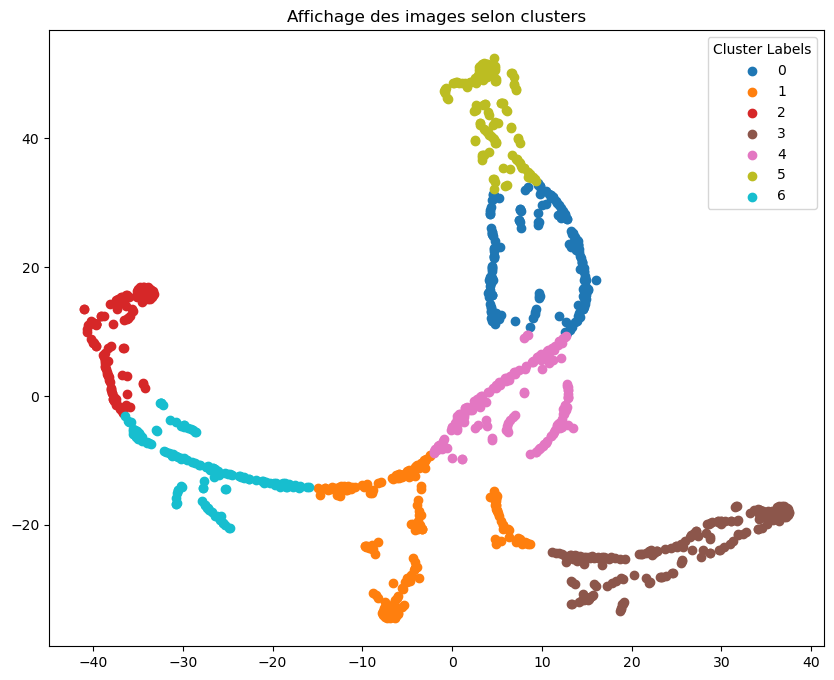

Adjusted Rand Index (ARI): 0.009906658596499874


In [30]:
visualize_and_evaluate(features, data_image['categorie'], '')